# Self Subduction Case 2

**Romain Beucher** romain.beucher (at) anu.edu.au

In [1]:
from underworld import UWGeodynamics as GEO
import numpy as np
from UWGeodynamics import visualisation as vis

loaded rc file /home/jovyan/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

In [3]:
half_rate = 1.0 * u.centimeter / u.year
model_length = 3000. * u.kilometer
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1603.15 * u.degK
bodyforce = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

In [4]:
Model = GEO.Model(elementRes=(256, 128), 
                  minCoord=(-1500. * u.kilometer, -700. * u.kilometer), 
                  maxCoord=(1500. * u.kilometer, 50. * u.kilometer), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

In [5]:
angle = 34.0 * u.degree
dx1 = np.cos(angle) * 375. * u.kilometer
dy1 = np.sin(angle) * 375. * u.kilometer 
dx2 = np.sin(angle) * 100. * u.kilometer
dy2 = np.cos(angle) * 100. * u.kilometer

In [6]:
polygon1 = GEO.shapes.Polygon([(-500. * u.kilometer, 0. * u.kilometer),
                              (-500. * u.kilometer - dx1, 0. * u.kilometer - dy1),
                              (-500. * u.kilometer - dx1 + dx2, 0. * u.kilometer - dy1 - dy2),
                              (-500. * u.kilometer + dx2, 0. * u.kilometer - dy2)])

polygon2 = GEO.shapes.Polygon([(-500. * u.kilometer, 0. * u.kilometer),
                              (-500. * u.kilometer, -100. * u.kilometer),
                              (1500. * u.kilometer , -100. * u.kilometer),
                              (1500. * u.kilometer, 0. * u.kilometer)])

polygon = polygon1 | polygon2

In [7]:
stickyAir = Model.add_material(name="Mantle", shape=GEO.shapes.Layer(top=Model.top, bottom=0. * u.kilometer))
Mantle = Model.add_material(name="Mantle", shape=GEO.shapes.Layer(top=0.*u.kilometer, bottom=Model.bottom))
Lithosphere = Model.add_material(name="Lithosphere", shape=polygon)


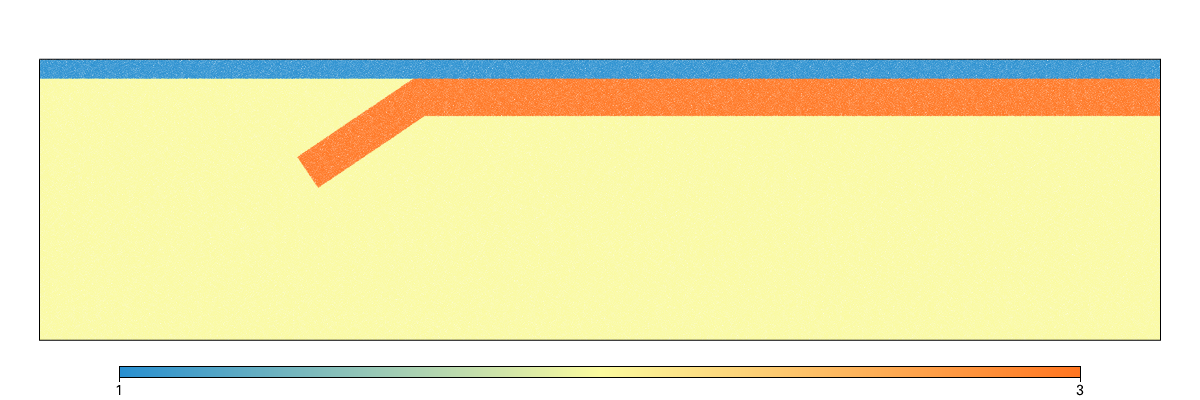

In [8]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, Model.materialField)
Fig.show()

In [13]:
x1, y1 = GEO.nd(-500. * u.km - dx1), GEO.nd(-dy1)
x2, y2 = GEO.nd(-500. * u.km - dx1 + dx2/2.0), GEO.nd(-dy1 - dy2/2.0)
x3, y3 = GEO.nd(-500. * u.km - dx1 + dx2), GEO.nd(-dy1 - dy2)

coords = np.ndarray((3, 2))
coords[:, 0] = np.array([x1, x2, x3])
coords[:, 1] = np.array([y1, y2, y3])

Model.add_passive_tracers(name="tip", vertices=coords)


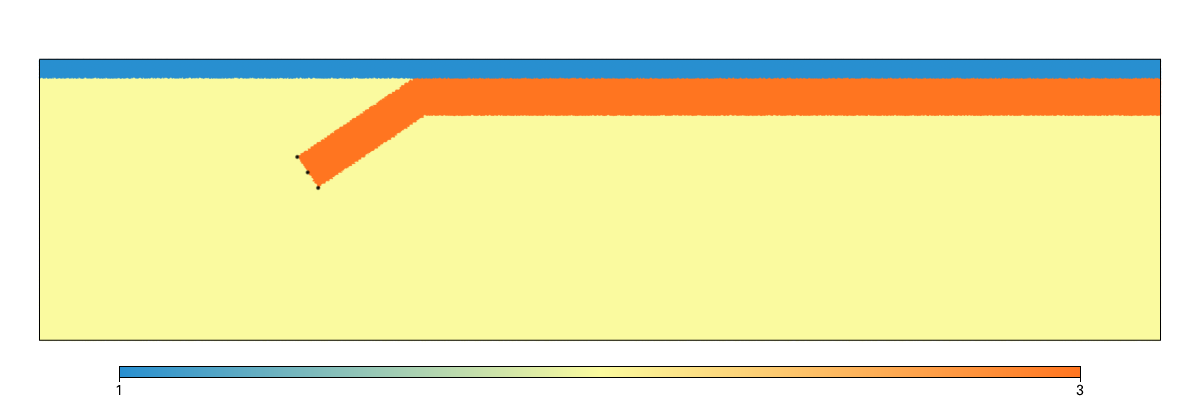

In [15]:
from UWGeodynamics import visualisation as vis
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.tip_tracers, pointSize=5.0)
Fig.Points(Model.swarm, Model.materialField, fn_size=3.0)
Fig.show()

In [16]:
stickyAir.viscosity = 1e19 * u.pascal * u.second
Mantle.viscosity = 1e21 * u.pascal * u.second
Lithosphere.viscosity = 1e23 * u.pascal * u.second

In [17]:
stickyAir.density = 1. * u.kilogram / u.metre**3
Mantle.density = 3200. * u.kilogram / u.metre**3
Lithosphere.density = 3300. * u.kilogram / u.metre**3

/home/jovyan/UWGeodynamics/UWGeodynamics/__init__.py:91: UserWarning: 'Dimensionalize' has been changed to 'dimensionalise', please use the later
  warnings.warn("""'Dimensionalize' has been changed to 'dimensionalise', please use the later""")



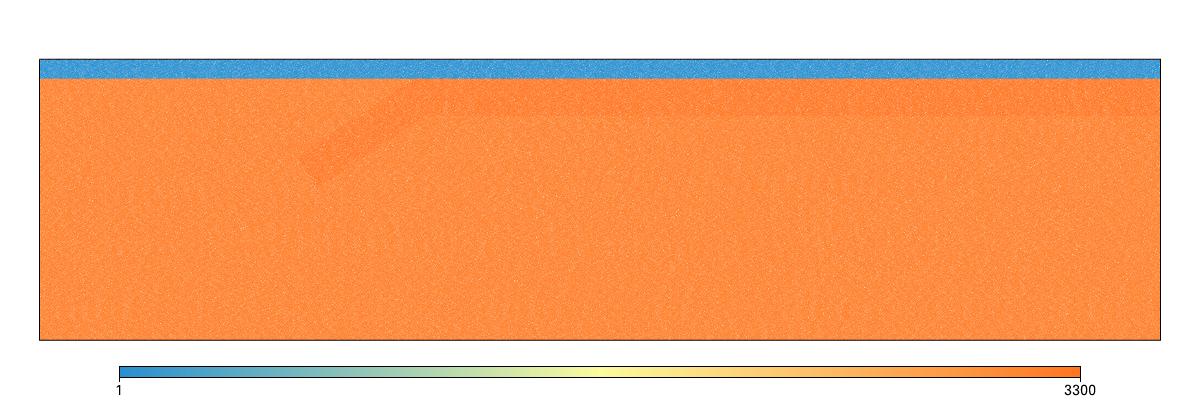

In [18]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, GEO.Dimensionalize(Model.densityField, u.kilogram / u.metre**3))
Fig.show()


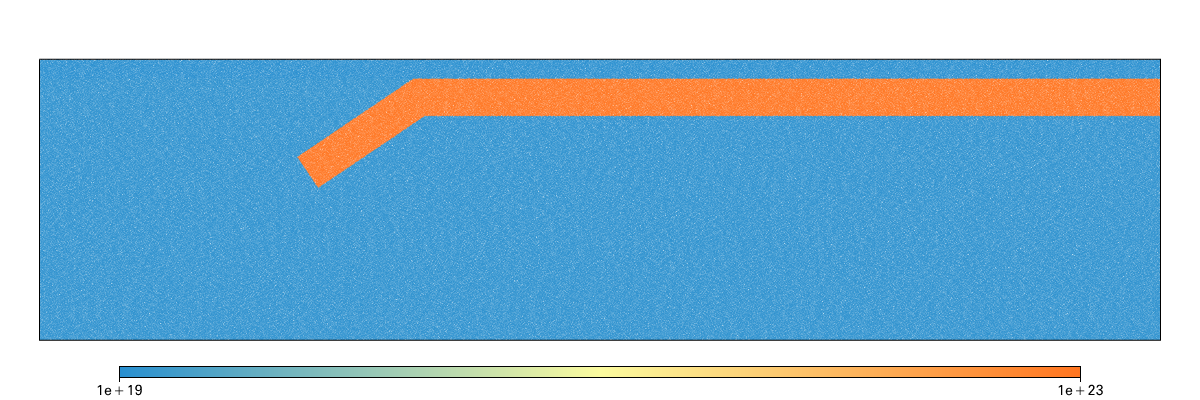

In [18]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, GEO.Dimensionalize(Model.viscosityField, u.pascal * u.second))
Fig.show()

In [19]:
Model.set_velocityBCs(left=[0., None],
                      right=[0., None],
                      bottom=[None, 0.],
                      top=[None, 0.])

In [20]:
Model.init_model(pressure="lithostatic")

In [21]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)

In [22]:
Model.run_for(nstep=1)

Running with UWGeodynamics version 2.9.3
Options:  -Q22_pc_type gkgdiag -force_correction True -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type preonly -A11_pc_type lu -A11_pc_factor_mat_solver_type mumps -scr_ksp_type fgmres -scr_ksp_rtol 1e-05 -A11_mg_active False
Step:     1 Model Time: 5147.1 year dt: 5147.1 year (2020-03-25 22:28:37)


1


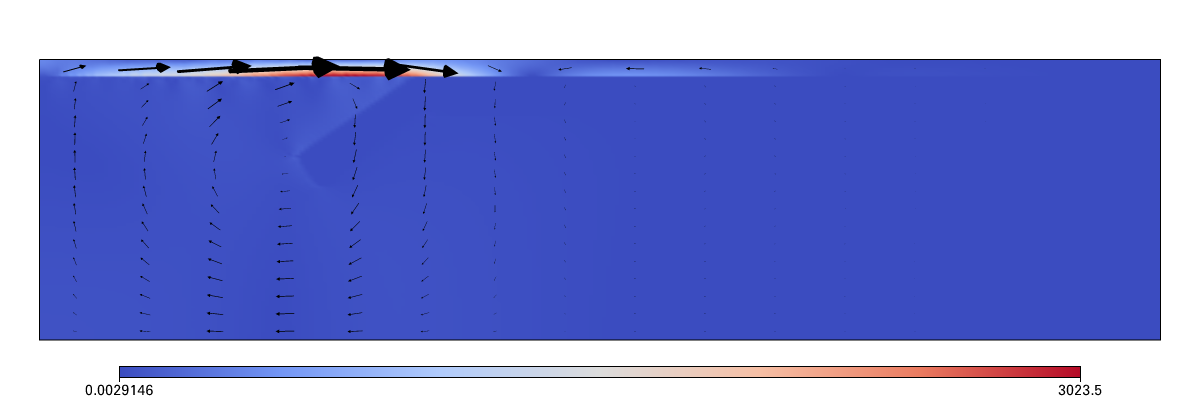

In [23]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, Model.strainRateField, logScale=False, colours="coolwarm")
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()